In [2]:
# imports, definitions, and data loading
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

with open("../infostates.open-hand-20m.json") as f:
    raw_data = json.load(f)
print("loaded {} infostates".format(len(raw_data)))
print(raw_data[0])

cards = [
    "Js",
    "Jc",
    "As",
    "Ks",
    "Qs",
    "Ts",
    "9s",
    "Ac",
    "Kc",
    "Qc",
    "Tc",
    "9c",
    "Ah",
    "Kh",
    "Qh",
    "Th",
    "9h",
    "Ad",
    "Kd",
    "Qd",
    "Td",
    "9d",
    "Jh",
    "Jd",
]

loaded 269187 infostates
{'infostate': 'QcTs9hJhQhJsPPPPPPP', 'hand': ['Qc', 'Ts', '9h', 'Jh', 'Qh'], 'policy': {'D': 0.05882357785466272, 'H': 0.8823528442906744, 'C': 0.05882357785466272}}


In [3]:
# Calculate pickup probs
def pickup_probs(data):
    df = pd.DataFrame.from_records(data)

    pickup_mask = df.policy.apply(lambda x: "T" in x)
    df = df[pickup_mask]
    df = df[df.infostate.str.endswith("JsPPP")]

    pickup_probs = []

    order = []
    for c in cards:
        total_take = 0
        count = 0
        card_mask = df.hand.apply(lambda x: c in x)
        avg = df[card_mask].policy.apply(lambda x: x["T"]).mean()
        order += [(c, avg)]
    order.sort(key=lambda x: x[1], reverse=True)

    order = [x[0] for x in order]

    for c1 in cards:
        for c2 in cards:
            if c1 == c2:
                pickup_probs += [(c1, c2, 0.5)]
            else:
                card_mask = df.hand.apply(lambda x: c1 in x and c2 in x)
                avg = df[card_mask].policy.apply(lambda x: x["T"]).mean()
                pickup_probs += [(c1, c2, avg)]

    return (pickup_probs, order)


probs, order = pickup_probs(raw_data)

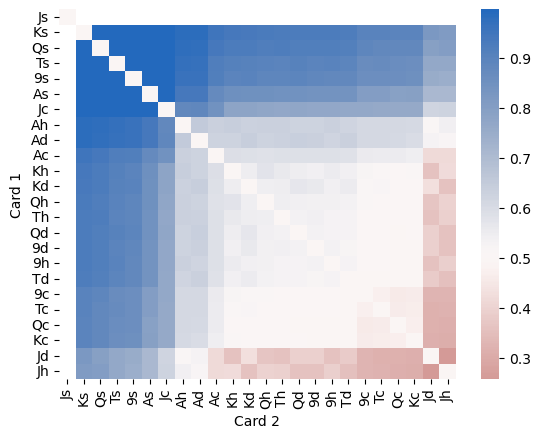

In [4]:
# Generate pickup vs pass heatmap
df = pd.DataFrame.from_records(probs, columns=["Card 1", "Card 2", "pickup_prob"])
df = df.pivot(index="Card 1", columns="Card 2")
df = df.reindex(order)
df = df["pickup_prob"].reindex(order, axis=1)


sns.heatmap(
    df,
    cmap=sns.color_palette("vlag_r", as_cmap=True),
    center=0.5,
    annot=False,
    fmt="0.2f",
)
plt.savefig("../../../docs/assets/pass-on-bower-2-heatmap.png")

I identified five major areas in the heatmap:

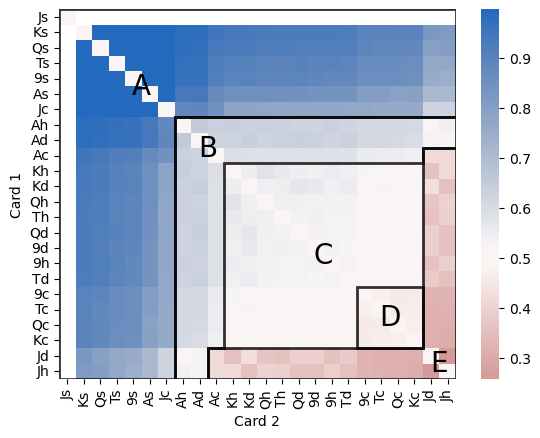

In [5]:
# Generate annotated heat map


ax = sns.heatmap(
    df,
    cmap=sns.color_palette("vlag_r", as_cmap=True),
    center=0.5,
    annot=False,
    fmt="0.2f",
)

import matplotlib.path as mpath
import matplotlib.patches as mpatches

Path = mpath.Path
spades = [
    (Path.MOVETO, (0, 0)),
    (Path.LINETO, (24, 0)),
    (Path.LINETO, (24, 7)),
    (Path.LINETO, (7, 7)),
    (Path.LINETO, (7, 24)),
    (Path.LINETO, (0, 24)),
    (Path.CLOSEPOLY, (0, 0)),
]

red_jacks = [
    (Path.MOVETO, (9, 24)),
    (Path.LINETO, (24, 24)),
    (Path.LINETO, (24, 9)),
    (Path.LINETO, (22, 9)),
    (Path.LINETO, (22, 22)),
    (Path.LINETO, (9, 22)),
    (Path.CLOSEPOLY, (9, 24)),
]

offsuit_aces = [
    (Path.MOVETO, (7, 24)),
    (Path.LINETO, (7, 7)),
    (Path.LINETO, (24, 7)),
    (Path.LINETO, (24, 9)),
    (Path.LINETO, (22, 9)),
    (Path.LINETO, (22, 10)),
    (Path.LINETO, (10, 10)),
    (Path.LINETO, (10, 22)),
    (Path.LINETO, (9, 22)),
    (Path.LINETO, (9, 24)),
    (Path.CLOSEPOLY, (7, 24)),
]

clubs = [
    (Path.MOVETO, (18, 18)),
    (Path.LINETO, (22, 18)),
    (Path.LINETO, (22, 22)),
    (Path.LINETO, (18, 22)),
    (Path.CLOSEPOLY, (18, 18)),
]


def add_patch(path, ax, color):
    codes, verts = zip(*path)
    path = mpath.Path(verts, codes)
    patch = mpatches.PathPatch(path, alpha=0.8, lw=2, edgecolor=color, fill=False)
    ax.add_patch(patch)


add_patch(spades, ax, "black")
add_patch(red_jacks, ax, "black")
add_patch(offsuit_aces, ax, "black")
add_patch(clubs, ax, "black")

ax.text(5, 5, "A", fontsize=20, color="black", ha="center", va="center")
ax.text(9, 9, "B", fontsize=20, color="black", ha="center", va="center")
ax.text(16, 16, "C", fontsize=20, color="black", ha="center", va="center")
ax.text(20, 20, "D", fontsize=20, color="black", ha="center", va="center")
ax.text(23, 23, "E", fontsize=20, color="black", ha="center", va="center")
plt.savefig("../../../docs/assets/pass-on-bower-2-heatmap-annotated.png")

Number of nodes in the last tree is: 1 with ccp_alpha: 0.21182836244904646


KeyboardInterrupt: 

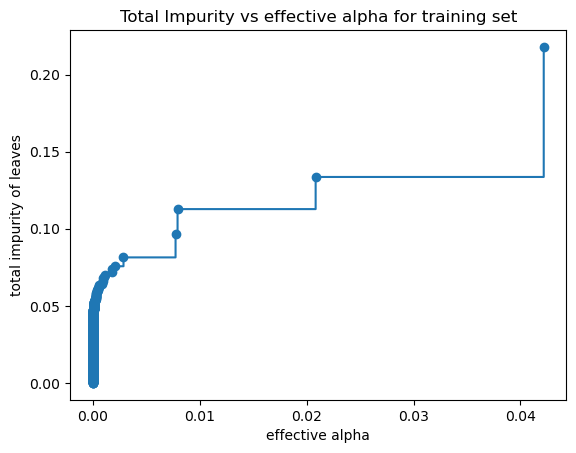

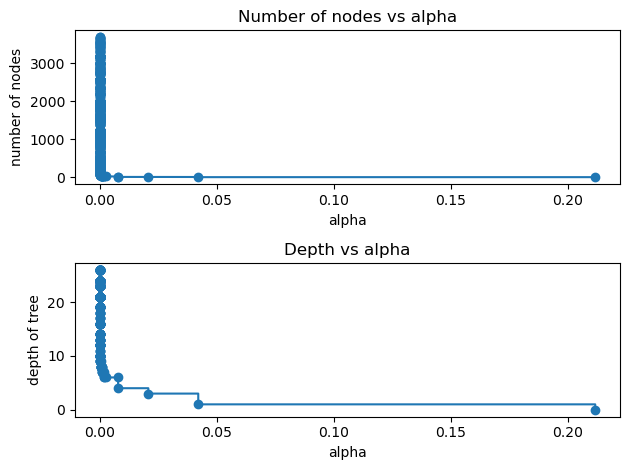

In [6]:
def create_decision_tree(data):
    df = pd.DataFrame.from_records(data)
    df = df[df.infostate.str.endswith("JsPPP")]
    # card_mask = df.hand.apply(lambda x: "Jc" in x)
    # df = df[card_mask]

    df["action"] = df.policy.apply(lambda x: max(x, key=x.get))

    for c in cards:
        df[c] = df.hand.apply(lambda x: c in x)

    df["num_spades"] = df.hand.apply(
        lambda x: len([c for c in x if c.endswith("s") or c == "Jc"])
    )
    df["num_clubs"] = df.hand.apply(
        lambda x: len([c for c in x if c.endswith("c") and c != "Jc"])
    )
    df["num_hearts"] = df.hand.apply(lambda x: len([c for c in x if c.endswith("h")]))
    df["num_diamons"] = df.hand.apply(lambda x: len([c for c in x if c.endswith("d")]))

    df["off_suit_aces"] = df.hand.apply(
        lambda x: len([c for c in x if c in ["Ac", "Ah", "Ad"]])
    )

    df["red_jack"] = df.hand.apply(lambda x: len([c for c in x if c in ["Jh", "Jd"]]))

    df["num_nines"] = df.hand.apply(lambda x: len([c for c in x if c.startswith("9")]))

    df = df.drop("infostate", axis=1)
    df = df.drop("policy", axis=1)
    df = df.drop("hand", axis=1)

    X_train = df.drop("action", axis=1)
    y_train = df.action
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    fig, ax = plt.subplots()
    ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs effective alpha for training set")

    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)
    print(
        "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
            clfs[-1].tree_.node_count, ccp_alphas[-1]
        )
    )

    node_counts = [clf.tree_.node_count for clf in clfs]
    depth = [clf.tree_.max_depth for clf in clfs]
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
    ax[0].set_xlabel("alpha")
    ax[0].set_ylabel("number of nodes")
    ax[0].set_title("Number of nodes vs alpha")
    ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("depth of tree")
    ax[1].set_title("Depth vs alpha")
    fig.tight_layout()

    train_scores = [clf.score(X_train, y_train) for clf in clfs]
    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.legend()
    plt.show()

    plt.figure(figsize=(12, 12))
    tree.plot_tree(
        clfs[-4],
        max_depth=5,
        feature_names=df.drop("action", axis=1).columns,
        class_names=["P", "T"],
    )

    plt.figure(figsize=(12, 12))
    tree.plot_tree(
        clfs[-5],
        max_depth=5,
        feature_names=df.drop("action", axis=1).columns,
        class_names=["P", "T"],
    )
    return clfs[-4], df.drop("action", axis=1).columns


clf, feature_names = create_decision_tree(raw_data)

In [ ]:
# Hands where pickup Jack by have no other spades


def print_no_spades_pickup(data):
    df = pd.DataFrame.from_records(data)
    df = df[df.infostate.str.endswith("JsPPP")]

    df["action"] = df.policy.apply(lambda x: max(x, key=x.get))

    df["num_spades"] = df.hand.apply(
        lambda x: len([c for c in x if c.endswith("s") or c == "Jc"])
    )

## What happens -- why is this recommended

Run a number of games where have certain hand -- categorize results for passing and taking the card -- use some of these as example play
    * For example, does having Jh or Jd make it more likely to euchre, so that's why taking it?

take stats:


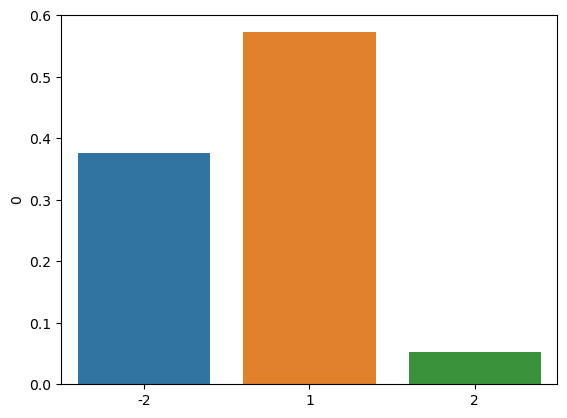

           0
-2  0.375260
1   0.571985
2   0.052755
total games: 25950
average score: 0.00023121387283236994
score dist: {'-2': 9738, '1': 14843, '2': 1369}
pass stats:


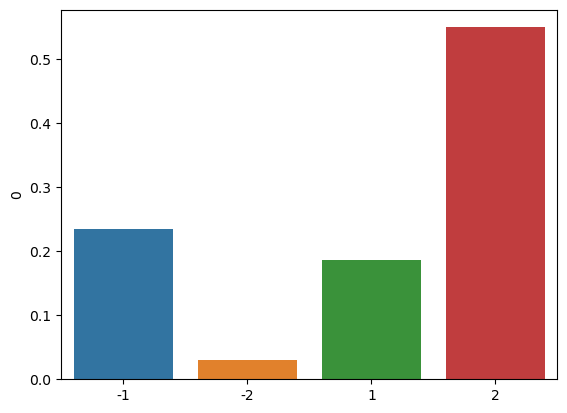

           0
-1  0.234836
-2  0.029827
1   0.186243
2   0.549094
total games: 25950
average score: 0.0003853564547206166
score dist: {'2': 14249, '-1': 6094, '-2': 774, '1': 4833}


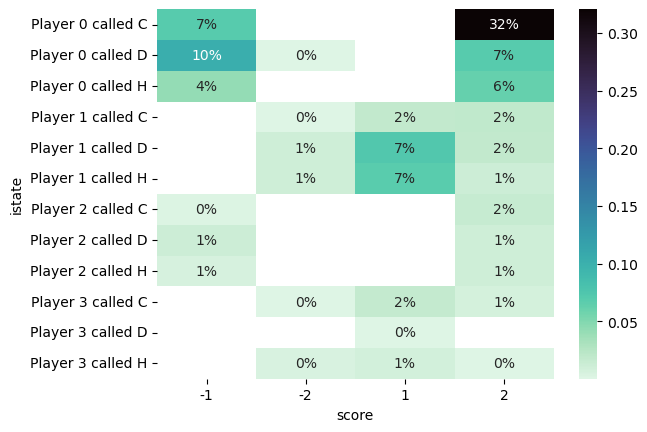

In [8]:
pass_counts = json.loads(
    """{
  "JcQcJhAh9d|Js|PPPPC|0C|": {
    "2": 8320,
    "-1": 1808
  },
  "JcQcJhAh9d|Js|PPPPPPD|2D|": {
    "2": 294,
    "-1": 318
  },
  "JcQcJhAh9d|Js|PPPPPPC|2C|": {
    "2": 414,
    "-1": 66
  },
  "JcQcJhAh9d|Js|PPPPPC|1C|": {
    "-2": 22,
    "2": 503,
    "1": 491
  },
  "JcQcJhAh9d|Js|PPPPPPPC|3C|": {
    "-2": 38,
    "2": 181,
    "1": 440
  },
  "JcQcJhAh9d|Js|PPPPPPH|2H|": {
    "2": 296,
    "-1": 160
  },
  "JcQcJhAh9d|Js|PPPPPH|1H|": {
    "-2": 288,
    "1": 1761,
    "2": 312
  },
  "JcQcJhAh9d|Js|PPPPPD|1D|": {
    "-2": 298,
    "1": 1904,
    "2": 475
  },
  "JcQcJhAh9d|Js|PPPPD|0D|": {
    "-2": 12,
    "2": 1814,
    "-1": 2642
  },
  "JcQcJhAh9d|Js|PPPPPPPH|3H|": {
    "1": 230,
    "2": 16,
    "-2": 116
  },
  "JcQcJhAh9d|Js|PPPPPPPD|3D|": {
    "1": 7
  },
  "JcQcJhAh9d|Js|PPPPH|0H|": {
    "2": 1624,
    "-1": 1100
  }
}
"""
)

take_counts = json.loads(
    """
{
  "JcQcJhAh9d|Js|PPPT|3S|Jh|": {
    "-2": 853,
    "1": 3173,
    "2": 294
  },
  "JcQcJhAh9d|Js|PPPT|3S|9d|": {
    "1": 3118,
    "-2": 714,
    "2": 542
  },
  "JcQcJhAh9d|Js|PPPT|3S|Jc|": {
    "1": 1472,
    "2": 31,
    "-2": 2842
  },
  "JcQcJhAh9d|Js|PPPT|3S|Ah|": {
    "2": 92,
    "-2": 1620,
    "1": 2575
  },
  "JcQcJhAh9d|Js|PPPT|3S|Js|": {
    "1": 1456,
    "-2": 2934,
    "2": 23
  },
  "JcQcJhAh9d|Js|PPPT|3S|Qc|": {
    "2": 387,
    "1": 3049,
    "-2": 775
  }
}
"""
)


def print_summary_stats(counts):
    total_games = 0
    total_score = 0
    score_dist = {}
    for istate, stats in counts.items():
        for score, count in stats.items():
            score_dist[score] = score_dist.get(score, 0) + count
            total_games += count
            total_score += int(score)

    df = pd.DataFrame.from_dict(score_dist, orient="index")
    df = df.sort_index()
    df[0] = df[0] / df[0].sum()
    sns.barplot(x=df.index, y=df[0])
    plt.show()
    print(df)

    print("total games: {}".format(total_games))
    print("average score: {}".format(total_score / total_games))
    print("score dist: {}".format(score_dist))


def istate_heatmap(counts):
    df = pd.DataFrame.from_records(
        [(i, j, counts[i][j]) for i in counts.keys() for j in counts[i].keys()],
        columns=["istate", "score", "count"],
    )
    df["istate"] = df["istate"].str[-3:-1]
    df["istate"] = "Player " + df["istate"].str[0] + " called " + df["istate"].str[1]
    total_games = df["count"].sum()
    df["count"] = df["count"] / total_games
    df = df.pivot(index="istate", columns="score", values="count")
    sns.heatmap(df, cmap="mako_r", annot=True, fmt="0.0%")
    plt.savefig("../../../docs/assets/pass-on-bower-2-JcQcJhAh9d-heatmap.png")


print("take stats:")
print_summary_stats(take_counts)

print("pass stats:")
print_summary_stats(pass_counts)


istate_heatmap(pass_counts)